# Getting Insights 
Using the existing 3 datasets (Customer demographic, customer address and transactions) as a labelled dataset, we are asked recommend which of these 1000 customers should be targeted to drive the most value for the organisation. So our problem can be explained in first we want to identify what criteria identifies customers who are worth investing in. Then, we need to develop a model (preferably Machine Learning model) that can identify new customers who are potential investments.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
transactions = pd.read_excel('data.xlsx',sheet_name = 1,header = 1)
customers = pd.read_excel('data.xlsx',sheet_name = 3,header = 1)
addresses = pd.read_excel('data.xlsx',sheet_name = 4,header = 1)

## Approach #1 : Hypothesize that total spending is Pareto distributed

The Pareto distribution, named after the Italian civil engineer, economist, and sociologist Vilfredo Pareto, is a power-law probability distribution that is used in description of social, quality control, scientific, geophysical, actuarial, and many other types of observable phenomena.

It states that around N% of the total contribution is actually produced by the square root of N of the population. Here, we hypothesize that the total profit contributed by customers is distributed according to Pareto's. So we can select the elite N percent that contributes the majority of the profit.

In [2]:
customers['total_spending'] = transactions.groupby('customer_id').sum().list_price
customers['total_spending'] = customers['total_spending'].fillna(0)

We can see that the total spending is calculated by grouping transactions by the customer id (so it's for every customer) then we sum up the paid price for all the transactions for each customer. We fill missing values with Zero as it means that there are probably no transactions recorded for this customer.

In [3]:
customers.sort_values(['total_spending'],axis=0,ascending=False)

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,tenure,total_spending
2183,2184,Lamar,Gladman,Male,49,1971-12-05,Statistician III,Health,Mass Customer,N,âð¿ ðªð¿ ðð¿ ðð¿ ðð¿ ðð¿,No,11.0,19071.32
1129,1130,Juli,Prine,Female,90,1964-12-06,Sales Associate,NaN,Mass Customer,N,2018-02-01 00:00:00,No,16.0,18349.27
1597,1598,Guendolen,Betterton,Female,87,1973-12-02,Safety Technician III,NaN,Mass Customer,N,100,No,11.0,18052.68
941,942,Shirley,Brook,Female,31,1974-02-07,Director of Sales,Financial Services,Mass Customer,N,1,Yes,14.0,17898.46
2788,2789,Violetta,Bucksey,Female,66,1992-11-30,Senior Editor,Financial Services,Affluent Customer,N,ãã¼ãã£ã¼ã¸è¡ããªãã,Yes,7.0,17258.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3656,3657,Wyatan,Rogeon,Male,95,1961-07-24,NaN,NaN,High Net Worth,N,ð¾ ð ð ð ð ð ð ð,No,8.0,0.00
3655,3656,Talia,Sidnell,Female,14,1976-12-24,NaN,Property,Mass Customer,N,!@#$%^&*(),Yes,3.0,0.00
3654,3655,Waldemar,Mostin,Male,82,1974-06-01,NaN,NaN,Mass Customer,N,ZÌ®ÌÍÌ ÍÍAÌ¥ÌÌÍÌ»ÌLÌ£ÍÍÌ¯Ì¹ÌÍGÌ»OÌ­ÌÌ®,Yes,19.0,0.00
3653,3654,Kenyon,Paddefield,U,78,NaT,Electrical Engineer,Manufacturing,Mass Customer,N,NaN,No,NaN,0.00


Here is the density plot of the total spending of the whole population.

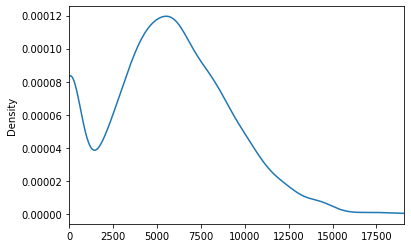

In [4]:
customers.total_spending.plot.density(xlim = [customers.total_spending.min(),customers.total_spending.max()])

Pearson's r :  -0.0029014429544094427


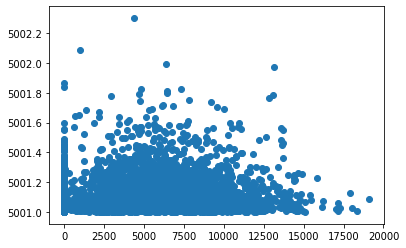

In [5]:
from scipy.stats import pearsonr
import scipy.stats as st
pareto_distribution = st.pareto.rvs(10,loc = 5000, size=customers.shape[0])
r = pearsonr(pareto_distribution,customers.total_spending)[0]
print("Pearson's r : ",r)
plt.scatter(customers.total_spending,pareto_distribution)
plt.show()

But on testing this hypothesis, we found that our total spending data doesn't by any mean correlate with a pareto distribution of the same base dimentions. Which means our first approach has failed.

# Approach #2 : Grouping

Another approach is to try grouping our customers across more than a demographic variable, maybe one resulting group contributes a significant portion of our profits.

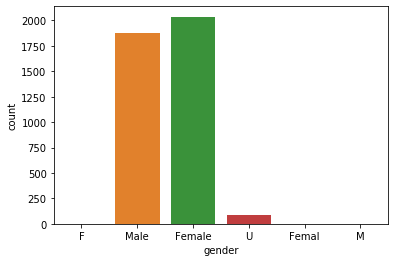

In [6]:
import seaborn as sns
sns.countplot('gender',data = customers)
plt.show()

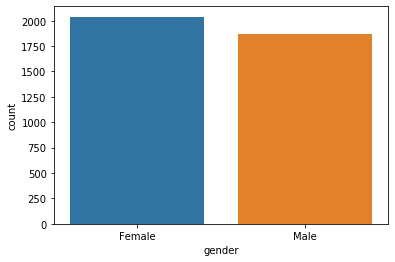

In [7]:
customers.loc[customers.gender == 'Femal','gender'] = 'Female'
customers.loc[customers.gender == 'F','gender'] = 'Female'
customers.loc[customers.gender == 'M','gender'] = 'Male'
customers.drop(customers[customers.gender == 'U'].index,inplace = True)
sns.countplot('gender',data = customers)
plt.show()

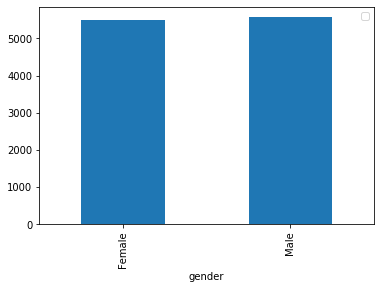

In [8]:
customers.groupby('gender').mean().plot.bar(y='total_spending')
plt.legend('')
plt.show()

So across the gender variable, we found that total spending is uniformaly distributed between males & females.

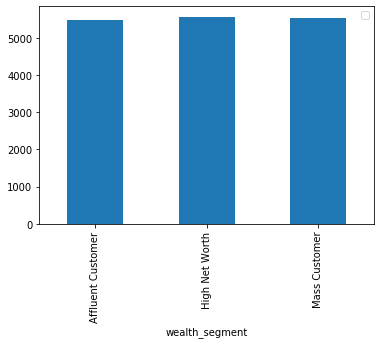

In [9]:
customers.groupby('wealth_segment').mean().plot.bar(y='total_spending')
plt.legend('')
plt.show()

The same situation appears on the wealth segment.

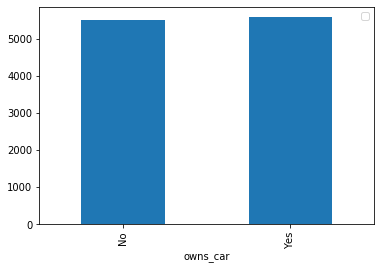

In [10]:
customers.groupby('owns_car').mean().plot.bar(y='total_spending')
plt.legend('')
plt.show()

And owning a car doesn't change alot of things apparently.

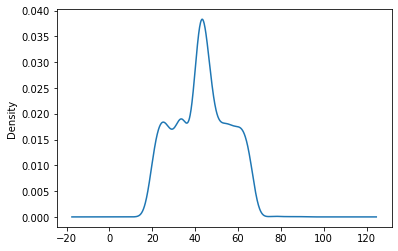

In [11]:
import numpy as np
customers['age'] = (((pd.to_datetime('2021-1-24') - customers['DOB'])/np.timedelta64(1, 'D'))/365).astype(int)
customers.age.plot.density()
plt.show()

The majority of our customers are between 40-60 years. Quite interesting.

In [12]:
customers['age_interval'] = pd.cut(customers.age,3)

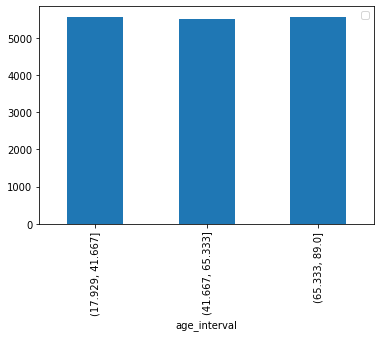

In [13]:
customers.groupby('age_interval').mean().plot.bar(y='total_spending')
plt.legend('')
plt.show()

And for the age intervals, it's still the same. So grouping doesn't seem apprperiate here as our data is radicaly uniform across all of our demographic groups. So our second approach fails too.

# Approach #3 : Finding Patterns


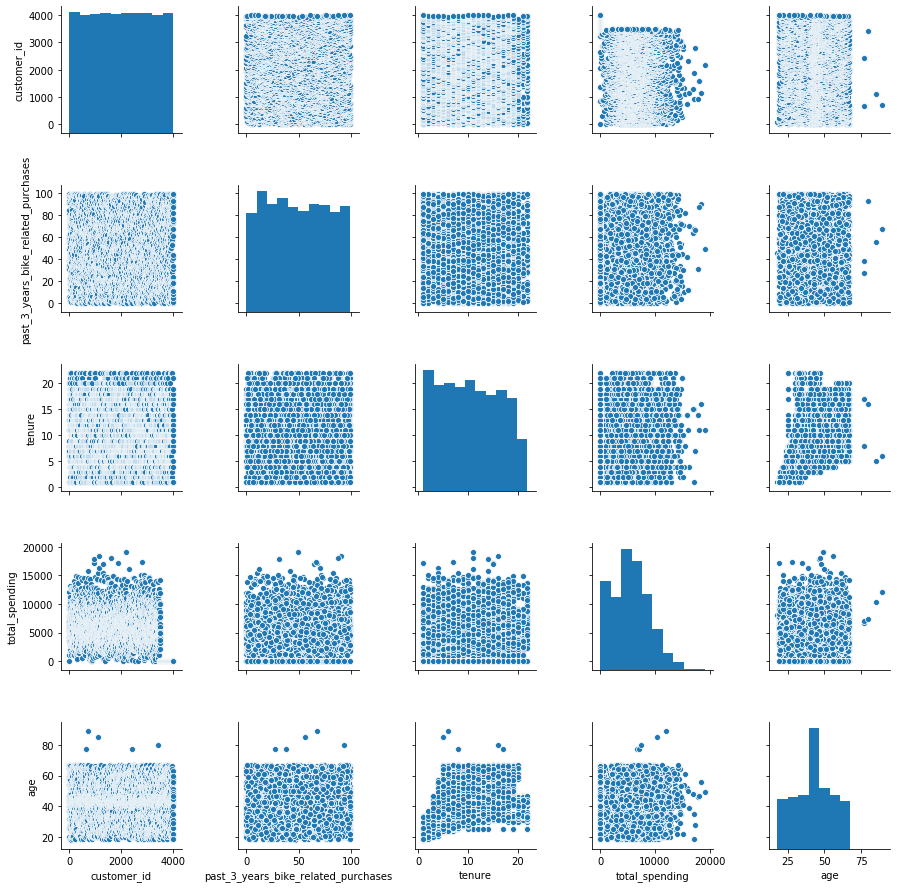

In [14]:
sns.pairplot(customers)

Here we tried observing any pattern in our data, but there isn't any which suggests we may try merging with other data like the addresses & geographic information, Or try evaluating customers from a different prespective. The third approach failed.

# Approach #4 : Geographical Distribution


In [15]:
customers_addresses = customers.merge(addresses,on = 'customer_id')
customers_addresses.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,...,owns_car,tenure,total_spending,age,age_interval,address,postcode,state,country,property_valuation
0,1,Laraine,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,...,Yes,11.0,0.00,67,"(65.333, 89.0]",060 Morning Avenue,2016,New South Wales,Australia,10
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,...,Yes,16.0,9084.45,40,"(17.929, 41.667]",6 Meadow Vale Court,2153,New South Wales,Australia,10
2,4,Talbot,NaN,Male,33,1961-10-03,NaN,IT,Mass Customer,N,...,No,7.0,9888.23,59,"(41.667, 65.333]",0 Holy Cross Court,4211,QLD,Australia,9
3,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,NaN,Affluent Customer,N,...,Yes,8.0,1047.72,43,"(41.667, 65.333]",17979 Del Mar Point,2448,New South Wales,Australia,4
4,6,Curr,Duckhouse,Male,35,1966-09-16,NaN,Retail,High Net Worth,N,...,Yes,13.0,5903.20,54,"(41.667, 65.333]",9 Oakridge Court,3216,VIC,Australia,9


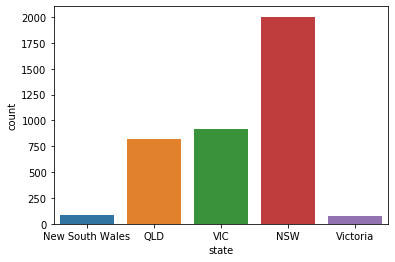

In [16]:
sns.countplot('state',data = customers_addresses)

After successfully merging our data, we can observe that most of our customers live in NSW. An intresting fact !

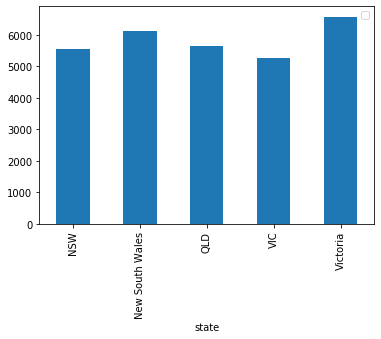

In [17]:
customers_addresses.groupby('state').mean().plot.bar(y='total_spending')
plt.legend('')
plt.show()

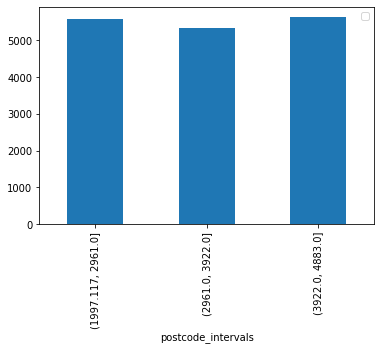

In [18]:
customers_addresses['postcode_intervals'] = pd.cut(customers_addresses.postcode,3)
customers_addresses.groupby('postcode_intervals').mean().plot.bar(y='total_spending')
plt.legend('')
plt.show()

And it doesn't change anything as the total spending is uniformaly distributed across the states & postal code intervals. Our fourth approach leads to nothing.

# Approach #5 : New Metric -> Average Purchase

Approach number five. I've gave up on total spending, it's radicaly uniform & doesn't tell anything really for a customer. What we will try here is to evaluate our customer according to their average purchase.

The idea is that a customer who on average spends more than other customers per one purchase, is worthy of enticing to make mor purchases. And in that way we can get to increase our profits in the best possible way. As he makes more & more expensive pruchases on average.

In [19]:
customers = customers_addresses
customers['number_of_purchases'] = transactions.groupby('customer_id').count().transaction_id
customers['average_purchase'] = customers['total_spending']/customers['number_of_purchases']
customers['average_purchase'] = customers['average_purchase'].fillna(0)
customers.sort_values(['average_purchase'],axis=0,ascending=False).head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,...,age,age_interval,address,postcode,state,country,property_valuation,postcode_intervals,number_of_purchases,average_purchase
2417,2477,Barney,Tilling,Male,25,1977-03-23,Electrical Engineer,Manufacturing,Affluent Customer,N,...,43,"(41.667, 65.333]",9248 Sugar Terrace,2530,NSW,Australia,9,"(1997.117, 2961.0]",1.0,14578.69
822,845,Koressa,Maris,Female,51,1973-12-24,Associate Professor,Manufacturing,Mass Customer,N,...,47,"(41.667, 65.333]",3387 Warrior Court,2527,NSW,Australia,7,"(1997.117, 2961.0]",1.0,12523.55
191,199,Verla,Alven,Female,61,1978-02-13,Junior Executive,Health,Mass Customer,N,...,42,"(41.667, 65.333]",7451 Jana Lane,2138,NSW,Australia,8,"(1997.117, 2961.0]",1.0,11648.85
2532,2593,Sharona,Yorkston,Female,69,1973-07-26,Nuclear Power Engineer,Manufacturing,Affluent Customer,N,...,47,"(41.667, 65.333]",6 Forest Avenue,2870,NSW,Australia,4,"(1997.117, 2961.0]",1.0,11062.61
2863,2930,Goddard,Benthall,Male,46,1997-07-25,Assistant Media Planner,Entertainment,Mass Customer,N,...,23,"(17.929, 41.667]",51 Bay Junction,2081,NSW,Australia,10,"(1997.117, 2961.0]",1.0,10903.63


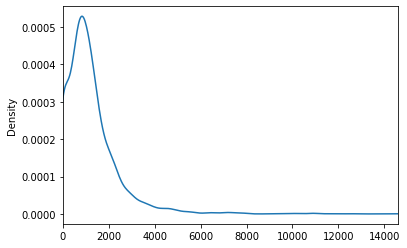

In [20]:
customers.average_purchase.plot.density(xlim = [customers.average_purchase.min(),customers.average_purchase.max()])
plt.show()

That graph looks promising, we see that in-fact a very little portion of the population spends much more money on average than the vast majority. We will investigate this situation more with a boxplot.

The number of elite customers :  977


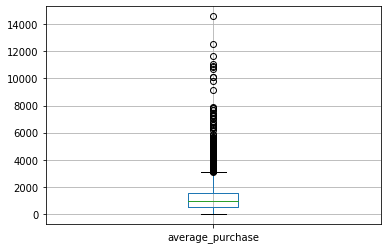

In [21]:
customers.boxplot('average_purchase')
print("The number of elite customers : ",len(customers[customers['average_purchase'] > customers.average_purchase.describe()['75%']]))

Finally, we got it. The total number of customers who are above the 75th percentile on average is around 977. Which is actualy optimal for our requirment as we needed to identify the most important 1000 customers, who I believe are those ones.

# Modeling

So now, after finding those elite customer. We need to develop a model that is able to identify an elite customer on seeing one using other variables. 

In [22]:
model_data = customers[['gender','past_3_years_bike_related_purchases','wealth_segment','deceased_indicator','age','state','property_valuation','average_purchase']]

In [23]:
model_data.head()

,gender,past_3_years_bike_related_purchases,wealth_segment,deceased_indicator,age,state,property_valuation,average_purchase
0,Female,93,Mass Customer,N,67,New South Wales,10,0.000000
1,Male,81,Mass Customer,N,40,New South Wales,10,825.859091
2,Male,33,Mass Customer,N,59,QLD,9,3296.076667
3,Female,56,Affluent Customer,N,43,New South Wales,4,130.965000
4,Male,35,High Net Worth,N,54,VIC,9,2951.600000


So we determine whether a customer is special or not if his average purchase exceeds the third quartile of the whole population

In [24]:
q3 = model_data.average_purchase.describe()['75%']
def is_special(averag_purchase):
    if(averag_purchase >= q3):
        return 1
    else:
        return 0
model_data['is_special'] = model_data.apply(lambda x: is_special(x.average_purchase), axis=1)  
model_data.head()

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,gender,past_3_years_bike_related_purchases,wealth_segment,deceased_indicator,age,state,property_valuation,average_purchase,is_special
0,Female,93,Mass Customer,N,67,New South Wales,10,0.000000,0
1,Male,81,Mass Customer,N,40,New South Wales,10,825.859091,0
2,Male,33,Mass Customer,N,59,QLD,9,3296.076667,1
3,Female,56,Affluent Customer,N,43,New South Wales,4,130.965000,0
4,Male,35,High Net Worth,N,54,VIC,9,2951.600000,1


In [25]:
processed_data = pd.DataFrame()
processed_data['gender'] = (model_data['gender'] == 'Female').astype(int)
processed_data['past_3_years_bike_related_purchases'] = (model_data['past_3_years_bike_related_purchases'] - model_data['past_3_years_bike_related_purchases'].mean()) / model_data['past_3_years_bike_related_purchases'].std()
def wealth_segment_encoder(wealth_segment):
    if(wealth_segment == 'Mass Customer'):
        return 0
    if(wealth_segment == 'Affluent Customer'):
        return 1
    if(wealth_segment == 'High Net Worth'):
        return 2
processed_data['wealth_segment'] = model_data.apply(lambda x: wealth_segment_encoder(x.wealth_segment), axis=1)  
processed_data['age'] = model_data['age']
processed_data['property_valuation'] = (model_data['property_valuation'] - model_data['property_valuation'].mean()) / model_data['property_valuation'].std()
def state_encoder(state):
    if(state == 'NSW' or state == 'New South Wales'):
        return 0
    if(state == 'QLD'):
        return 1
    if(state == 'VIC'):
        return 2
    if(state == 'Victoria'):
        return 3
processed_data['state'] = model_data.apply(lambda x: state_encoder(x.state), axis=1)  
processed_data['is_special'] = model_data['is_special']


That previous chunk is all about processing the data so it's more clear to our model. You don't need to read it, unless you want to.

In [26]:
processed_data.shape
processed_data.head()

,gender,past_3_years_bike_related_purchases,wealth_segment,age,property_valuation,state,is_special
0,1,1.527888,0,67,0.880488,0,0
1,0,1.110905,0,40,0.880488,0,0
2,0,-0.557026,0,59,0.526517,1,1
3,1,0.242191,1,43,-1.243335,0,0
4,0,-0.487529,2,54,0.526517,2,1


So next, we will split the data into train & test sets, instentiate a random forest model from the library xgboost, then we will identify it's suitable hyper-parameters through 5 fold cross-validation then we will train & test that model & observe it's performance

In [27]:
from sklearn.model_selection import train_test_split
X = processed_data.drop('is_special',axis = 1)
y = processed_data.is_special
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25,random_state = 42)

In [28]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
model = xgb.XGBClassifier()
params = {
    'learning_rate' :[0.2,0.02,0.002],
    'max_depth': list(range(3,11)) ,
    'n_estimators' :[50,100,150]
}
SCV = GridSearchCV(estimator = model,param_grid = params,scoring='accuracy',cv=5,verbose=1)
SCV.fit(X_train,y_train)
print("Best parameters found: ", SCV.best_params_)
print("Best accuracy : ", SCV.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters found:  {'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 100}
Best accuracy :  0.7478676219720232


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:   57.1s finished


In [29]:
model = xgb.XGBClassifier(learning_rate = 0.02,max_depth = 3,n_estimators = 100)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))
print("Overall Accuracy : ",np.mean(y_test == y_pred)*100,"%")

              precision    recall  f1-score   support

           0       0.76      1.00      0.86       738
           1       0.00      0.00      0.00       239

    accuracy                           0.76       977
   macro avg       0.38      0.50      0.43       977
weighted avg       0.57      0.76      0.65       977

Overall Accuracy :  75.53735926305015 %


D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In conclusion, we reach 75% accuracy with acceptable recall & precision in spotting an elite customer without reviewing his pruchase data, which is extremly good in case of new-coming customers who haven't made enough pruchases yet to apply regular analysis. Will that customer be worth investing in? or not? We only know 75% of the answer.